# **Sign Language (MNIST) Classification using Deep Learning**


# **Background**
The goal of this project is to classify sign language images to letters.
* Reference - https://www.kaggle.com/datasets/datamunge/sign-language-mnist

   The dataset represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds.

# **Imports**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from random import sample
%matplotlib inline

import sys
import warnings

my_seed = 512
np.random.seed(my_seed)
import random 
random.seed(my_seed)

from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, LSTM, RepeatVector, TimeDistributed, Embedding, UpSampling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam,Adadelta
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential,Model
from sklearn.preprocessing import LabelBinarizer

# **Import Data**

In [12]:
if 'google.colab' in sys.modules:
    from google.colab import files
    uploaded = files.upload()

Saving sign_mnist_test.csv to sign_mnist_test.csv


In [39]:
df_train = pd.read_csv("sign_mnist_train.csv")
df_test = pd.read_csv("sign_mnist_test.csv")

# **EDA**

In [40]:
# The dataset is in the form of labels and pixel values (1-784) which is 28*28 image.
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [41]:
# Shape
print(df_train.shape)
print(df_test.shape)

(27455, 785)
(7172, 785)


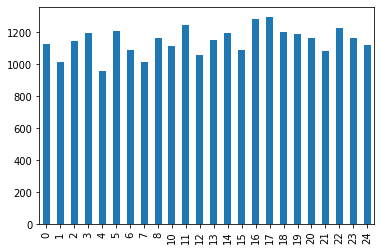

In [18]:
# Check the balance of the dataset 
df_train['label'].value_counts().sort_index().plot(kind = 'bar')

In [20]:
# Check for missing values
print(df_train.isnull().sum().sum())
print(df_test.isnull().sum().sum())

0
0


In [21]:
# Check for outliers
print(((df_train>255) | (df_train<0)).sum().sum())
print(((df_test>255) | (df_test<0)).sum().sum())

0
0


# **Data Processing Pre-Modeling**

In [43]:
# Parse numbers as floats
df_train = df_train.astype('float32')
df_test = df_test.astype('float32')

In [44]:
# Declare target variable
y_train = df_train['label']
y_test = df_test['label']

# Convert the target to categorical (MNIST is a classification problem)
y_train = np_utils.to_categorical(y_train, 25)
y_test = np_utils.to_categorical(y_test, 25)

In [45]:
# Declare feature vector
df_train = df_train.drop(['label'], axis = 1)
df_test = df_test.drop(['label'], axis = 1)
x_train = df_train.values
x_test = df_test.values

# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

# Prepare the data for CNN model (requires a 4-dimensional input)
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
# 1st layer - for the different images
# 2nd and 3rd - for the width and height of the images
# 4th - for the color data (channels) (in our case the images are in greyscale, so there is only 1 channel).

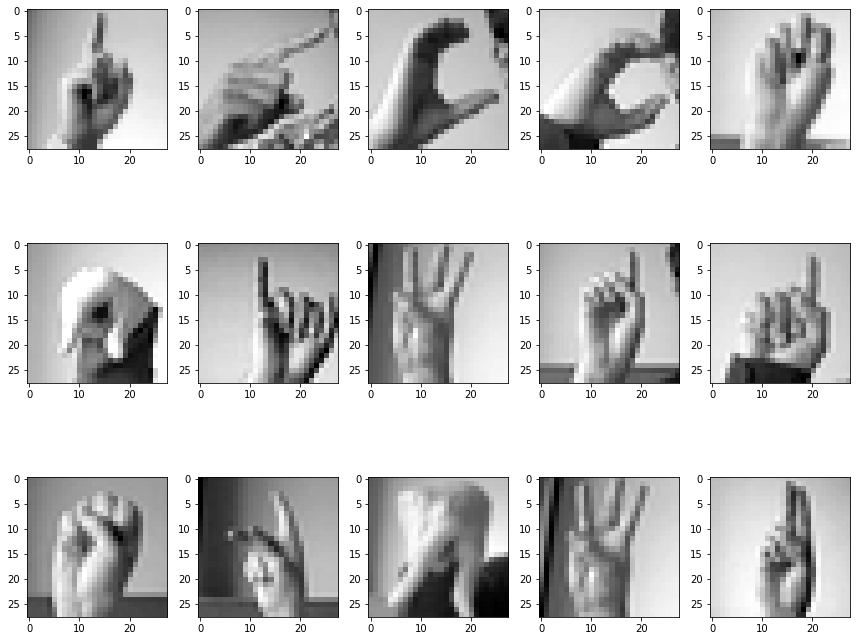

In [50]:
# Display images after data processing
row = 0
f, ax = plt.subplots(3,5) 
f.set_size_inches(12, 12)

for i in range(3):
    for j in range(5):
        ax[i,j].imshow(x_train[row].reshape(28, 28) , cmap="gray")
        row += 1
    plt.tight_layout()  

# **Modeling**

In [15]:
# Model configuration
batch_size = 128 # 128 samples are fed to the model in each step.
img_width, img_height, img_num_channels = 28, 28, 1 # Define the image width, height and the number of channels.
loss_function = categorical_crossentropy # For multiclass classification scenarios - categorical crossentropy loss is a good choice.
optimizer = Adam() # The optimizer adapts the weights.
no_classes = 25 # Our dataset has 25 classes.
no_epochs = 100 # We will train the model for 100 iterations (epochs).
verbosity = 1 # We set verbosity mode to 1 (True), showing all the output on screen.
input_shape = (img_width, img_height, img_num_channels) # Determine the shape of the data

In [28]:
# Create the model
def create_model(x_train, y_train, x_test, y_test, batch_size, no_epochs, input_shape, no_classes, data_augmentation=False, batch_normalization=False, image_data_generator=False, reduce_learning_rate=False):


  # Instatinate model 
  if image_data_generator and reduce_learning_rate:
    datagen = ImageDataGenerator(
            featurewise_center=False,  # Set input mean to 0 over the dataset.
            samplewise_center=False,  # Set each sample mean to 0.
            featurewise_std_normalization=False,  # Divide inputs by std of the dataset.
            samplewise_std_normalization=False,  # Divide each input by its std.
            zca_whitening=False,  # Apply ZCA whitening.
            rotation_range=10,  # Randomly rotate images in the range (degrees, 0 to 180).
            zoom_range = 0.1, # Randomly zoom image.
            width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width).
            height_shift_range=0.1,  # Randomly shift images vertically (fraction of total height).
            horizontal_flip=False,  # Randomly flip images.
            vertical_flip=False)  # Randomly flip images.
    datagen.fit(x_train) # Fits the data generator to the train data.
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001) # Reduce learning rate when a metric has stopped improving.
    model = Sequential()
 
  elif data_augmentation:
    model = Sequential([preprocessing.RandomRotation(0.1), # Randomly rotate
                        preprocessing.RandomZoom(0.1), # Randomly zoom 
                        preprocessing.RandomContrast(0.1) # Randomly adjusts contrast 
                        ])
  else:
    model = Sequential()


  # Add a Conv2D layer (creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs, the layer will transform the input image into a very abstract representation which can be used by densely-connected layers to generate a classification.
  model.add(Conv2D(filters=64, # Number of filters that should be learned by the convolutional layer.
                  kernel_size=(3, 3), # The height and width of the 2D convolution window.
                  padding='same', # Results in padding with zeros evenly to the left/right or up/down of the input.
                  activation='relu', # Activation function to use.
                  input_shape=input_shape)) # Provide this argument when using a layer as the 1st layer in a model.
  

  # Add batch normalization (Optional)
  if batch_normalization: model.add(BatchNormalization())


  # Add a max pooling layer (to keep the size of the data small)
  model.add(MaxPooling2D(pool_size=(2, 2)))


  # Add dropout regularization layer (randomly selected neurons are ignored during training, meaning that their contribution to the activation of downstream neurons is temporally removed on the forward pass, and any weight updates are not applied to the neuron on the backward pass)
  model.add(Dropout(0.2))


  # Add another convolutional layer (usually with more filters).
  model.add(Conv2D(filters=64,kernel_size=(3, 3),activation='relu'))
  if batch_normalization: model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(filters=128,kernel_size=(3, 3),activation='relu'))
  if batch_normalization: model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.3))


  # Flatten the output (dense layers can only handle 1D data, so we convert the multidimensional feature map output by the final Conv2D layer into 1D format first, the flatten layer can be considered as the "final" features).
  model.add(Flatten())
  if batch_normalization: model.add(BatchNormalization())


  # Add two Dense layers to generate the classification (the last layer activate with Softmax, which allows us to generate multiclass probability distribution, which is what we need if we want to answer the question "which class is most likely?").
  model.add(Dense(256, activation='relu'))
  if batch_normalization: model.add(BatchNormalization())
  model.add(Dense(units=no_classes,activation='softmax'))


  # Compile the model
  model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])

  # Fit data to model
  if image_data_generator and reduce_learning_rate:                      
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=no_epochs, validation_data=(x_test, y_test), callbacks=[reduce_lr])  
  
  else:
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=no_epochs, verbose=verbosity, validation_data=(x_test, y_test))


  # Model evaluation
  score = model.evaluate(x_test, y_test, verbose=1)

  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  (pd.DataFrame(history.history)**0.5).plot()

  return model

# **CNN (Convolutional Neural Networks)**

Epoch 1/100
215/215 [==============================] - 3s 11ms/step - loss: 2.1577 - accuracy: 0.3223 - val_loss: 0.7054 - val_accuracy: 0.7567
Epoch 2/100
215/215 [==============================] - 2s 9ms/step - loss: 0.5583 - accuracy: 0.8019 - val_loss: 0.3403 - val_accuracy: 0.8861
Epoch 3/100
215/215 [==============================] - 2s 9ms/step - loss: 0.3091 - accuracy: 0.8924 - val_loss: 0.2423 - val_accuracy: 0.9233
Epoch 4/100
215/215 [==============================] - 2s 9ms/step - loss: 0.1938 - accuracy: 0.9332 - val_loss: 0.1947 - val_accuracy: 0.9347
Epoch 5/100
215/215 [==============================] - 2s 8ms/step - loss: 0.1424 - accuracy: 0.9518 - val_loss: 0.1556 - val_accuracy: 0.9477
Epoch 6/100
215/215 [==============================] - 2s 8ms/step - loss: 0.1077 - accuracy: 0.9632 - val_loss: 0.1534 - val_accuracy: 0.9509
Epoch 7/100
215/215 [==============================] - 2s 9ms/step - loss: 0.0884 - accuracy: 0.9708 - val_loss: 0.1550 - val_accuracy: 0.951

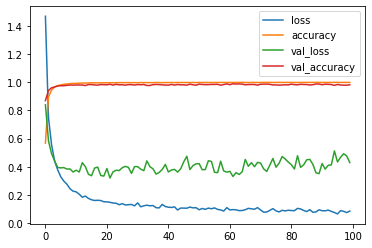

In [30]:
CNN = create_model(x_train, y_train, x_test, y_test,
                   batch_size, no_epochs, input_shape, no_classes,
                   data_augmentation=False, batch_normalization=False,
                   image_data_generator=False, reduce_learning_rate=False)

**Model 1 Summary:**

A simple CNN generated **96.4% accuracy**.

Let's try to increase the accuracy using different methods.

---

# **CNN + Data Augmentation**

In order to avoid overfitting problem, we need to expand artificially our dataset ,the idea is to alter the training data with small transformations to reproduce variations.

Example of data augmentation techniques - grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, etc.

Epoch 1/100
215/215 [==============================] - 3s 11ms/step - loss: 2.3853 - accuracy: 0.2557 - val_loss: 1.2275 - val_accuracy: 0.6025
Epoch 2/100
215/215 [==============================] - 2s 11ms/step - loss: 1.2443 - accuracy: 0.5788 - val_loss: 0.7027 - val_accuracy: 0.7882
Epoch 3/100
215/215 [==============================] - 2s 11ms/step - loss: 0.8927 - accuracy: 0.6928 - val_loss: 0.5254 - val_accuracy: 0.8180
Epoch 4/100
215/215 [==============================] - 2s 11ms/step - loss: 0.7072 - accuracy: 0.7521 - val_loss: 0.5132 - val_accuracy: 0.8175
Epoch 5/100
215/215 [==============================] - 3s 12ms/step - loss: 0.5917 - accuracy: 0.7922 - val_loss: 0.3883 - val_accuracy: 0.8710
Epoch 6/100
215/215 [==============================] - 2s 10ms/step - loss: 0.5085 - accuracy: 0.8219 - val_loss: 0.3737 - val_accuracy: 0.8806
Epoch 7/100
215/215 [==============================] - 2s 10ms/step - loss: 0.4578 - accuracy: 0.8425 - val_loss: 0.3299 - val_accuracy:

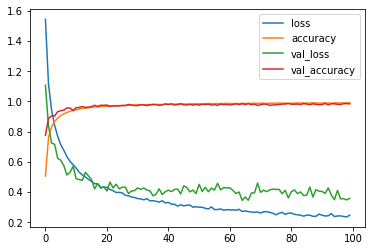

In [31]:
CNN_with_DA = create_model(x_train, y_train, x_test, y_test,
                           batch_size, no_epochs, input_shape, no_classes,
                           data_augmentation=True, batch_normalization=False,
                           image_data_generator=False, reduce_learning_rate=False)

**Model 2 Summary:**

Using different data augmentation techniques - we improved the performance of the model to **96.9% accuracy**.


---

# **CNN + Data Augmentation +  Batch Normalization**

Batch Normalization (BN) was developed to prevent internal covariate shift (which occurs when the distribution of the activations of a layer shifts significantly throughout training).

BN is used so that the distribution of the inputs to a specific layer doesn't change over time due to parameter updates from each batch. It uses batch statistics to do the normalizing, and then uses the batch normalization parameters (gamma and beta) to make sure that the transformation inserted in the network can represent the identity transform.

Epoch 1/100
215/215 [==============================] - 5s 14ms/step - loss: 0.7600 - accuracy: 0.7572 - val_loss: 4.2538 - val_accuracy: 0.1274
Epoch 2/100
215/215 [==============================] - 3s 15ms/step - loss: 0.1475 - accuracy: 0.9547 - val_loss: 0.8229 - val_accuracy: 0.7313
Epoch 3/100
215/215 [==============================] - 3s 15ms/step - loss: 0.0766 - accuracy: 0.9776 - val_loss: 0.2747 - val_accuracy: 0.9117
Epoch 4/100
215/215 [==============================] - 3s 13ms/step - loss: 0.0441 - accuracy: 0.9876 - val_loss: 0.1490 - val_accuracy: 0.9579
Epoch 5/100
215/215 [==============================] - 3s 12ms/step - loss: 0.0348 - accuracy: 0.9903 - val_loss: 0.1234 - val_accuracy: 0.9656
Epoch 6/100
215/215 [==============================] - 3s 12ms/step - loss: 0.0280 - accuracy: 0.9927 - val_loss: 0.2015 - val_accuracy: 0.9400
Epoch 7/100
215/215 [==============================] - 3s 12ms/step - loss: 0.0229 - accuracy: 0.9935 - val_loss: 0.1687 - val_accuracy:

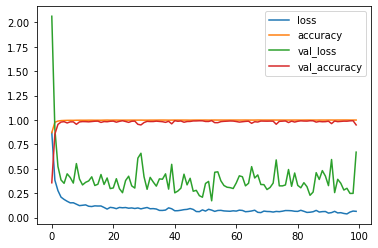

In [32]:
CNN_with_DA_and_BN = create_model(x_train, y_train, x_test, y_test,
                                  batch_size, no_epochs, input_shape, no_classes,
                                  data_augmentation=True, batch_normalization=True,
                                  image_data_generator=False, reduce_learning_rate=False)

**Model 3 Summary:**

By adding batch normalization - the performance of the model got worse - **90.1% accuracy**, therefore, we will proceed without it.

---

# **CNN + ImageDataGenerator + Learning Rates**

Reduce learning rate when a metric has stopped improving. 

Models often benefit from reducing the learning rate once learning stagnates. This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced.

Epoch 1/100
215/215 [==============================] - 8s 36ms/step - loss: 2.2354 - accuracy: 0.3069 - val_loss: 0.9568 - val_accuracy: 0.6762 - lr: 0.0010
Epoch 2/100
215/215 [==============================] - 8s 39ms/step - loss: 1.0460 - accuracy: 0.6476 - val_loss: 0.4842 - val_accuracy: 0.8487 - lr: 0.0010
Epoch 3/100
215/215 [==============================] - 8s 35ms/step - loss: 0.7576 - accuracy: 0.7429 - val_loss: 0.3226 - val_accuracy: 0.9091 - lr: 0.0010
Epoch 4/100
215/215 [==============================] - 8s 38ms/step - loss: 0.6023 - accuracy: 0.7961 - val_loss: 0.3108 - val_accuracy: 0.8940 - lr: 0.0010
Epoch 5/100
215/215 [==============================] - 8s 35ms/step - loss: 0.5093 - accuracy: 0.8255 - val_loss: 0.1673 - val_accuracy: 0.9559 - lr: 0.0010
Epoch 6/100
215/215 [==============================] - 8s 35ms/step - loss: 0.4385 - accuracy: 0.8480 - val_loss: 0.1457 - val_accuracy: 0.9604 - lr: 0.0010
Epoch 7/100
215/215 [==============================] - 8s 

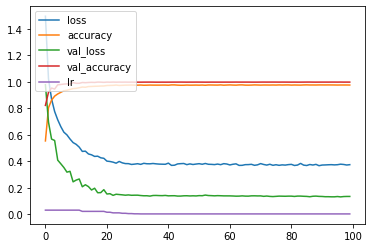

In [34]:
CNN_with_IDG_and_LR = create_model(x_train, y_train, x_test, y_test,
                                   batch_size, no_epochs, input_shape, no_classes,
                                   data_augmentation=False, batch_normalization=False,
                                   image_data_generator=True, reduce_learning_rate=True)

In [36]:
print(CNN_with_IDG_and_LR.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 4, 4, 128)       

**Model 4 Summary:**

By adding 2 methods, the performance of the model significantly improved to - **99.6% accuracy**.
1. ImageDataGenerator - ensures that the model receives new variations of the images at each epoch.
2. ReduceLROnPlateau - reduces the learning rate by a factor of 0.5 if no improvement is seen for 2 epochs.

---

## **Results and Conclusions**

1. In this project, in order to classify sign language images to letters, I built 4 Neural Networks.
2. The effect of Data Augmentation and Batch Normalization on the performance, surprisingly, was bad as we saw a decrease in accuracy.
3. The best performing model with the highest accuracy (99.6%) is - Convolutional Neural Network with ImageDataGenerator and Learning Rates optimization.